In [1]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
import pickle
BASE_PATH = "/kaggle/input/cifar-10-and-cifar-10-c/cifar-10-python/cifar-10-batches-py"

train_data = []
train_label = []

def unpickle(file):
    with open(file ,'rb') as f:
        data_dict = pickle.load(f , encoding = 'bytes')
    return data_dict
        
for i in range(1,6):
    batch_path = os.path.join(BASE_PATH , f"data_batch_{i}" )
    batch = unpickle(batch_path)
    train_data.append(batch[b'data'])
    train_label.extend(batch[b'labels'])

X_train = np.vstack(train_data)      
y_train = np.array(train_label)     

In [3]:
test_data = []
test_label = []

test_path = os.path.join(BASE_PATH , 'test_batch')
test_batch = unpickle(test_path)
test_data.append(batch[b'data'])
test_label.extend(batch[b'labels'])

y_test = np.array(test_label)    

In [4]:
X_train.shape

(50000, 3072)

In [5]:
# I will calculate CIFAR MEAN AND CIFAR STD And use it as a normalizing technique for the 3 the channels of the RGB

X = X_train.astype('float32') / 255.0

X = X.reshape(-1, 3, 32, 32) # X_train shape is (50000, 3072) which is a flattened version 
X = np.transpose(X, (0, 2, 3, 1))#this changes the arrangement just like we have permute in torch
print(X.shape)
mean = X.mean(axis=(0, 1, 2))
std = X.std(axis=(0, 1, 2))

print("Mean:", mean)
print("Std:", std)   

(50000, 32, 32, 3)
Mean: [0.4914009  0.48215896 0.4465308 ]
Std: [0.24703279 0.24348423 0.26158753]


In [6]:
CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD  = (0.2470, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),         
    transforms.RandomHorizontalFlip(p=0.5),        
    transforms.ColorJitter(brightness=0.1, contrast=0.1,
                           saturation=0.1, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

In [7]:
def cifar_flat_to_pil(img_flat):
    r = img_flat[0:1024].reshape(32,32)
    g = img_flat[1024:2048].reshape(32,32)
    b = img_flat[2048:3072].reshape(32,32)
    img = np.stack([r,g,b], axis=2).astype('uint8')
    pil_img = Image.fromarray(img).convert("RGB")
    return pil_img

# Converting a Fla

In [8]:
from PIL import Image
def cifar_dataset_to_pil(flat_images):
    pil_images = []
    for img_flat in flat_images:
        pil_img = cifar_flat_to_pil(img_flat)  # pass the array directly
        pil_images.append(pil_img)
    return pil_images

train_data_flat = np.vstack(train_data)
test_data_flat = np.vstack(test_data)   

train_images = cifar_dataset_to_pil(train_data_flat)
test_images = cifar_dataset_to_pil(test_data_flat)

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import multiprocessing

class CIFAR10_dataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.has_labels = labels is not None
        print(f"\nLoading CIFAR10 Dataset... Total Len: {len(images)} | Labeled: {self.has_labels}\n{'-'*50}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        if self.has_labels:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return {"img": img, "label": label}
        else:
            return {"img": img}


train_images_split, val_images, y_train_split, y_val = train_test_split(
    train_images, y_train,
    test_size=0.2,         
    random_state=42,       
    stratify=y_train        
)

In [10]:
train_dataset = CIFAR10_dataset(train_images_split, y_train_split, transform=train_transform)
val_dataset = CIFAR10_dataset(val_images, y_val, transform=test_transform)
test_dataset = CIFAR10_dataset(test_images, labels=None, transform=test_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=multiprocessing.cpu_count(),
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=multiprocessing.cpu_count(),
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=multiprocessing.cpu_count(),
    pin_memory=True,
    persistent_workers=True
)


Loading CIFAR10 Dataset... Total Len: 40000 | Labeled: True
--------------------------------------------------

Loading CIFAR10 Dataset... Total Len: 10000 | Labeled: True
--------------------------------------------------

Loading CIFAR10 Dataset... Total Len: 10000 | Labeled: False
--------------------------------------------------


In [11]:
from torch import nn

class AdvancedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(AdvancedCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32 * 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32 * 2, out_channels=64 * 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64 * 2, out_channels=64 * 2, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64 * 2, out_channels=128 * 2, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128 * 2, out_channels=128 * 2, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128 * 2, out_channels=128 * 2, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=128 * 2, out_channels=256 * 2, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(in_channels=256 * 2, out_channels=256 * 2, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=256 * 2, out_channels=256 * 2, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(32 * 2)
        self.bn2 = nn.BatchNorm2d(128 * 2)
        self.bn3 = nn.BatchNorm2d(256 * 2)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout2d(0.2)

        self.fc1 = nn.Linear(4096 * 2, 4096 * 2)
        self.fc2 = nn.Linear(4096 * 2, 2048 * 2)
        self.fc3 = nn.Linear(2048 * 2, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)

        x = self.relu(self.bn2(self.conv4(x)))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.maxpool(x)
        x = self.dropout(x)

        x = self.relu(self.bn3(self.conv7(x)))
        x = self.relu(self.conv8(x))
        x = self.relu(self.conv9(x))
        x = self.maxpool(x)
        x = self.dropout(x)

        x = torch.flatten(x, start_dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

#Initiating the Custom CNN Model
num_classes = 10
net = AdvancedCNN(num_classes)
print(net)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Params: ", count_parameters(net))

AdvancedCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
print("Model moved to:", device)

Model moved to: cuda


In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay=1e-6, momentum=0.9)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, min_lr=0.00001)
epochs = 50

Epoch 1/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 1/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 22.76it/s]



Epoch 1 Results:
  Train Loss: 1.8856 | Train Acc: 28.14%
  Val Loss: 1.5120 | Val Acc: 44.06%
  Val Precision: 0.4533 | Recall: 0.4406 | F1: 0.4406
  LR: 0.010000
NEW BEST MODEL! Val Acc: 44.06%


Epoch 2/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 2/50 [Val]: 100%|██████████| 79/79 [00:03<00:00, 20.04it/s]



Epoch 2 Results:
  Train Loss: 1.4561 | Train Acc: 46.01%
  Val Loss: 1.3737 | Val Acc: 52.04%
  Val Precision: 0.5457 | Recall: 0.5204 | F1: 0.5077
  LR: 0.010000
NEW BEST MODEL! Val Acc: 52.04%


Epoch 3/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 3/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.45it/s]



Epoch 3 Results:
  Train Loss: 1.2430 | Train Acc: 54.95%
  Val Loss: 1.1089 | Val Acc: 60.51%
  Val Precision: 0.6374 | Recall: 0.6051 | F1: 0.6048
  LR: 0.010000
NEW BEST MODEL! Val Acc: 60.51%


Epoch 4/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 4/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.28it/s]



Epoch 4 Results:
  Train Loss: 1.0839 | Train Acc: 61.07%
  Val Loss: 0.9910 | Val Acc: 65.43%
  Val Precision: 0.6597 | Recall: 0.6543 | F1: 0.6463
  LR: 0.010000
NEW BEST MODEL! Val Acc: 65.43%


Epoch 5/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 5/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.58it/s]



Epoch 5 Results:
  Train Loss: 0.9723 | Train Acc: 65.47%
  Val Loss: 1.1438 | Val Acc: 61.33%
  Val Precision: 0.7032 | Recall: 0.6133 | F1: 0.6022
  LR: 0.010000


Epoch 6/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 6/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.62it/s]



Epoch 6 Results:
  Train Loss: 0.8924 | Train Acc: 68.53%
  Val Loss: 0.7845 | Val Acc: 72.98%
  Val Precision: 0.7465 | Recall: 0.7298 | F1: 0.7336
  LR: 0.010000
NEW BEST MODEL! Val Acc: 72.98%


Epoch 7/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 7/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.53it/s]



Epoch 7 Results:
  Train Loss: 0.8199 | Train Acc: 71.28%
  Val Loss: 0.6900 | Val Acc: 75.87%
  Val Precision: 0.7777 | Recall: 0.7587 | F1: 0.7559
  LR: 0.010000
NEW BEST MODEL! Val Acc: 75.87%


Epoch 8/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 8/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.64it/s]



Epoch 8 Results:
  Train Loss: 0.7632 | Train Acc: 73.22%
  Val Loss: 0.6342 | Val Acc: 78.40%
  Val Precision: 0.8011 | Recall: 0.7840 | F1: 0.7846
  LR: 0.010000
NEW BEST MODEL! Val Acc: 78.40%


Epoch 9/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 9/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.45it/s]



Epoch 9 Results:
  Train Loss: 0.7105 | Train Acc: 75.04%
  Val Loss: 0.6661 | Val Acc: 78.06%
  Val Precision: 0.7874 | Recall: 0.7806 | F1: 0.7767
  LR: 0.010000


Epoch 10/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 10/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.54it/s]



Epoch 10 Results:
  Train Loss: 0.6678 | Train Acc: 76.87%
  Val Loss: 0.5769 | Val Acc: 80.16%
  Val Precision: 0.8106 | Recall: 0.8016 | F1: 0.7989
  LR: 0.010000
NEW BEST MODEL! Val Acc: 80.16%


Epoch 11/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 11/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.46it/s]



Epoch 11 Results:
  Train Loss: 0.6260 | Train Acc: 78.08%
  Val Loss: 0.6301 | Val Acc: 78.92%
  Val Precision: 0.8087 | Recall: 0.7892 | F1: 0.7904
  LR: 0.010000


Epoch 12/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 12/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.60it/s]



Epoch 12 Results:
  Train Loss: 0.5927 | Train Acc: 79.46%
  Val Loss: 0.5063 | Val Acc: 82.60%
  Val Precision: 0.8306 | Recall: 0.8260 | F1: 0.8239
  LR: 0.010000
NEW BEST MODEL! Val Acc: 82.60%


Epoch 13/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 13/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.44it/s]



Epoch 13 Results:
  Train Loss: 0.5677 | Train Acc: 80.22%
  Val Loss: 0.4760 | Val Acc: 84.02%
  Val Precision: 0.8438 | Recall: 0.8402 | F1: 0.8407
  LR: 0.010000
NEW BEST MODEL! Val Acc: 84.02%


Epoch 14/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 14/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.58it/s]



Epoch 14 Results:
  Train Loss: 0.5411 | Train Acc: 81.39%
  Val Loss: 0.4652 | Val Acc: 84.06%
  Val Precision: 0.8457 | Recall: 0.8406 | F1: 0.8385
  LR: 0.010000
NEW BEST MODEL! Val Acc: 84.06%


Epoch 15/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 15/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.60it/s]



Epoch 15 Results:
  Train Loss: 0.5086 | Train Acc: 82.46%
  Val Loss: 0.4588 | Val Acc: 84.32%
  Val Precision: 0.8479 | Recall: 0.8432 | F1: 0.8432
  LR: 0.010000
NEW BEST MODEL! Val Acc: 84.32%


Epoch 16/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 16/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.58it/s]



Epoch 16 Results:
  Train Loss: 0.4964 | Train Acc: 82.88%
  Val Loss: 0.4436 | Val Acc: 84.81%
  Val Precision: 0.8612 | Recall: 0.8481 | F1: 0.8488
  LR: 0.010000
NEW BEST MODEL! Val Acc: 84.81%


Epoch 17/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 17/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.61it/s]



Epoch 17 Results:
  Train Loss: 0.4697 | Train Acc: 83.82%
  Val Loss: 0.4290 | Val Acc: 85.18%
  Val Precision: 0.8583 | Recall: 0.8518 | F1: 0.8531
  LR: 0.010000
NEW BEST MODEL! Val Acc: 85.18%


Epoch 18/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 18/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.44it/s]



Epoch 18 Results:
  Train Loss: 0.4533 | Train Acc: 84.43%
  Val Loss: 0.4063 | Val Acc: 86.69%
  Val Precision: 0.8688 | Recall: 0.8669 | F1: 0.8660
  LR: 0.010000
NEW BEST MODEL! Val Acc: 86.69%


Epoch 19/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 19/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.54it/s]



Epoch 19 Results:
  Train Loss: 0.4380 | Train Acc: 84.88%
  Val Loss: 0.4059 | Val Acc: 86.89%
  Val Precision: 0.8765 | Recall: 0.8689 | F1: 0.8702
  LR: 0.010000
NEW BEST MODEL! Val Acc: 86.89%


Epoch 20/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 20/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.48it/s]



Epoch 20 Results:
  Train Loss: 0.4213 | Train Acc: 85.33%
  Val Loss: 0.3639 | Val Acc: 87.84%
  Val Precision: 0.8802 | Recall: 0.8784 | F1: 0.8780
  LR: 0.010000
NEW BEST MODEL! Val Acc: 87.84%


Epoch 21/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 21/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.67it/s]



Epoch 21 Results:
  Train Loss: 0.4076 | Train Acc: 85.87%
  Val Loss: 0.3814 | Val Acc: 87.00%
  Val Precision: 0.8784 | Recall: 0.8700 | F1: 0.8711
  LR: 0.010000


Epoch 22/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 22/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.56it/s]



Epoch 22 Results:
  Train Loss: 0.3931 | Train Acc: 86.50%
  Val Loss: 0.3690 | Val Acc: 87.68%
  Val Precision: 0.8799 | Recall: 0.8768 | F1: 0.8763
  LR: 0.010000


Epoch 23/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 23/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.63it/s]



Epoch 23 Results:
  Train Loss: 0.3725 | Train Acc: 86.95%
  Val Loss: 0.3510 | Val Acc: 87.83%
  Val Precision: 0.8814 | Recall: 0.8783 | F1: 0.8785
  LR: 0.010000


Epoch 24/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 24/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.60it/s]



Epoch 24 Results:
  Train Loss: 0.3679 | Train Acc: 87.37%
  Val Loss: 0.3424 | Val Acc: 88.25%
  Val Precision: 0.8838 | Recall: 0.8825 | F1: 0.8822
  LR: 0.010000
NEW BEST MODEL! Val Acc: 88.25%


Epoch 25/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 25/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.45it/s]



Epoch 25 Results:
  Train Loss: 0.3517 | Train Acc: 87.64%
  Val Loss: 0.3400 | Val Acc: 88.48%
  Val Precision: 0.8861 | Recall: 0.8848 | F1: 0.8845
  LR: 0.010000
NEW BEST MODEL! Val Acc: 88.48%


Epoch 26/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 26/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.45it/s]



Epoch 26 Results:
  Train Loss: 0.3443 | Train Acc: 87.95%
  Val Loss: 0.3307 | Val Acc: 88.97%
  Val Precision: 0.8930 | Recall: 0.8897 | F1: 0.8901
  LR: 0.010000
NEW BEST MODEL! Val Acc: 88.97%


Epoch 27/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 27/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.63it/s]



Epoch 27 Results:
  Train Loss: 0.3405 | Train Acc: 88.12%
  Val Loss: 0.3463 | Val Acc: 88.15%
  Val Precision: 0.8865 | Recall: 0.8815 | F1: 0.8818
  LR: 0.010000


Epoch 28/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 28/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.59it/s]



Epoch 28 Results:
  Train Loss: 0.3228 | Train Acc: 88.77%
  Val Loss: 0.3418 | Val Acc: 88.70%
  Val Precision: 0.8928 | Recall: 0.8870 | F1: 0.8882
  LR: 0.010000


Epoch 29/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 29/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.67it/s]



Epoch 29 Results:
  Train Loss: 0.3133 | Train Acc: 89.26%
  Val Loss: 0.3399 | Val Acc: 88.50%
  Val Precision: 0.8901 | Recall: 0.8850 | F1: 0.8826
  LR: 0.010000


Epoch 30/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 30/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.64it/s]



Epoch 30 Results:
  Train Loss: 0.3031 | Train Acc: 89.35%
  Val Loss: 0.3725 | Val Acc: 87.98%
  Val Precision: 0.8919 | Recall: 0.8798 | F1: 0.8809
  LR: 0.010000


Epoch 31/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 31/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.62it/s]



Epoch 31 Results:
  Train Loss: 0.2971 | Train Acc: 89.58%
  Val Loss: 0.3327 | Val Acc: 89.54%
  Val Precision: 0.8997 | Recall: 0.8954 | F1: 0.8960
  LR: 0.010000
NEW BEST MODEL! Val Acc: 89.54%


Epoch 32/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 32/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.51it/s]



Epoch 32 Results:
  Train Loss: 0.2881 | Train Acc: 90.14%
  Val Loss: 0.3114 | Val Acc: 89.61%
  Val Precision: 0.9012 | Recall: 0.8961 | F1: 0.8974
  LR: 0.010000
NEW BEST MODEL! Val Acc: 89.61%


Epoch 33/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 33/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.57it/s]



Epoch 33 Results:
  Train Loss: 0.2793 | Train Acc: 90.31%
  Val Loss: 0.3063 | Val Acc: 90.30%
  Val Precision: 0.9058 | Recall: 0.9030 | F1: 0.9034
  LR: 0.010000
NEW BEST MODEL! Val Acc: 90.30%


Epoch 34/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 34/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.52it/s]



Epoch 34 Results:
  Train Loss: 0.2705 | Train Acc: 90.57%
  Val Loss: 0.3041 | Val Acc: 90.08%
  Val Precision: 0.9026 | Recall: 0.9008 | F1: 0.9010
  LR: 0.010000


Epoch 35/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 35/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.44it/s]



Epoch 35 Results:
  Train Loss: 0.2635 | Train Acc: 90.91%
  Val Loss: 0.2887 | Val Acc: 90.62%
  Val Precision: 0.9064 | Recall: 0.9062 | F1: 0.9057
  LR: 0.010000
NEW BEST MODEL! Val Acc: 90.62%


Epoch 36/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 36/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.50it/s]



Epoch 36 Results:
  Train Loss: 0.2604 | Train Acc: 90.99%
  Val Loss: 0.3049 | Val Acc: 90.01%
  Val Precision: 0.9051 | Recall: 0.9001 | F1: 0.9011
  LR: 0.010000


Epoch 37/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 37/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.50it/s]



Epoch 37 Results:
  Train Loss: 0.2580 | Train Acc: 91.04%
  Val Loss: 0.3120 | Val Acc: 90.09%
  Val Precision: 0.9056 | Recall: 0.9009 | F1: 0.9018
  LR: 0.010000


Epoch 38/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 38/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.62it/s]



Epoch 38 Results:
  Train Loss: 0.2433 | Train Acc: 91.45%
  Val Loss: 0.2860 | Val Acc: 91.05%
  Val Precision: 0.9108 | Recall: 0.9105 | F1: 0.9105
  LR: 0.010000
NEW BEST MODEL! Val Acc: 91.05%


Epoch 39/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 39/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.55it/s]



Epoch 39 Results:
  Train Loss: 0.2433 | Train Acc: 91.45%
  Val Loss: 0.2743 | Val Acc: 91.28%
  Val Precision: 0.9130 | Recall: 0.9128 | F1: 0.9127
  LR: 0.010000
NEW BEST MODEL! Val Acc: 91.28%


Epoch 40/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 40/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.59it/s]



Epoch 40 Results:
  Train Loss: 0.2351 | Train Acc: 91.79%
  Val Loss: 0.3197 | Val Acc: 89.64%
  Val Precision: 0.9035 | Recall: 0.8964 | F1: 0.8968
  LR: 0.010000


Epoch 41/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 41/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.58it/s]



Epoch 41 Results:
  Train Loss: 0.2277 | Train Acc: 91.93%
  Val Loss: 0.2686 | Val Acc: 91.49%
  Val Precision: 0.9169 | Recall: 0.9149 | F1: 0.9153
  LR: 0.010000
NEW BEST MODEL! Val Acc: 91.49%


Epoch 42/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 42/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.54it/s]



Epoch 42 Results:
  Train Loss: 0.2217 | Train Acc: 92.14%
  Val Loss: 0.2790 | Val Acc: 91.18%
  Val Precision: 0.9121 | Recall: 0.9118 | F1: 0.9117
  LR: 0.010000


Epoch 43/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 43/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.59it/s]



Epoch 43 Results:
  Train Loss: 0.2147 | Train Acc: 92.48%
  Val Loss: 0.3180 | Val Acc: 90.43%
  Val Precision: 0.9075 | Recall: 0.9043 | F1: 0.9043
  LR: 0.010000


Epoch 44/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 44/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.70it/s]



Epoch 44 Results:
  Train Loss: 0.2141 | Train Acc: 92.55%
  Val Loss: 0.2940 | Val Acc: 90.56%
  Val Precision: 0.9089 | Recall: 0.9056 | F1: 0.9056
  LR: 0.010000


Epoch 45/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 45/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.60it/s]



Epoch 45 Results:
  Train Loss: 0.2077 | Train Acc: 92.62%
  Val Loss: 0.2635 | Val Acc: 91.66%
  Val Precision: 0.9164 | Recall: 0.9166 | F1: 0.9162
  LR: 0.010000
NEW BEST MODEL! Val Acc: 91.66%


Epoch 46/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 46/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.61it/s]



Epoch 46 Results:
  Train Loss: 0.2043 | Train Acc: 92.88%
  Val Loss: 0.2843 | Val Acc: 90.80%
  Val Precision: 0.9109 | Recall: 0.9080 | F1: 0.9081
  LR: 0.010000


Epoch 47/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 47/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.57it/s]



Epoch 47 Results:
  Train Loss: 0.2006 | Train Acc: 93.02%
  Val Loss: 0.3015 | Val Acc: 90.80%
  Val Precision: 0.9096 | Recall: 0.9080 | F1: 0.9074
  LR: 0.010000


Epoch 48/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 48/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.63it/s]



Epoch 48 Results:
  Train Loss: 0.1940 | Train Acc: 93.14%
  Val Loss: 0.2740 | Val Acc: 91.37%
  Val Precision: 0.9185 | Recall: 0.9137 | F1: 0.9144
  LR: 0.010000


Epoch 49/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 49/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.55it/s]



Epoch 49 Results:
  Train Loss: 0.1908 | Train Acc: 93.35%
  Val Loss: 0.2694 | Val Acc: 91.41%
  Val Precision: 0.9169 | Recall: 0.9141 | F1: 0.9147
  LR: 0.010000


Epoch 50/50 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 50/50 [Val]: 100%|██████████| 79/79 [00:04<00:00, 18.54it/s]



Epoch 50 Results:
  Train Loss: 0.1799 | Train Acc: 93.59%
  Val Loss: 0.3021 | Val Acc: 90.84%
  Val Precision: 0.9086 | Recall: 0.9084 | F1: 0.9077
  LR: 0.010000

Training Complete! Best Val Acc: 91.66%
Training history saved to 'model_results/best_model_training_history.csv'


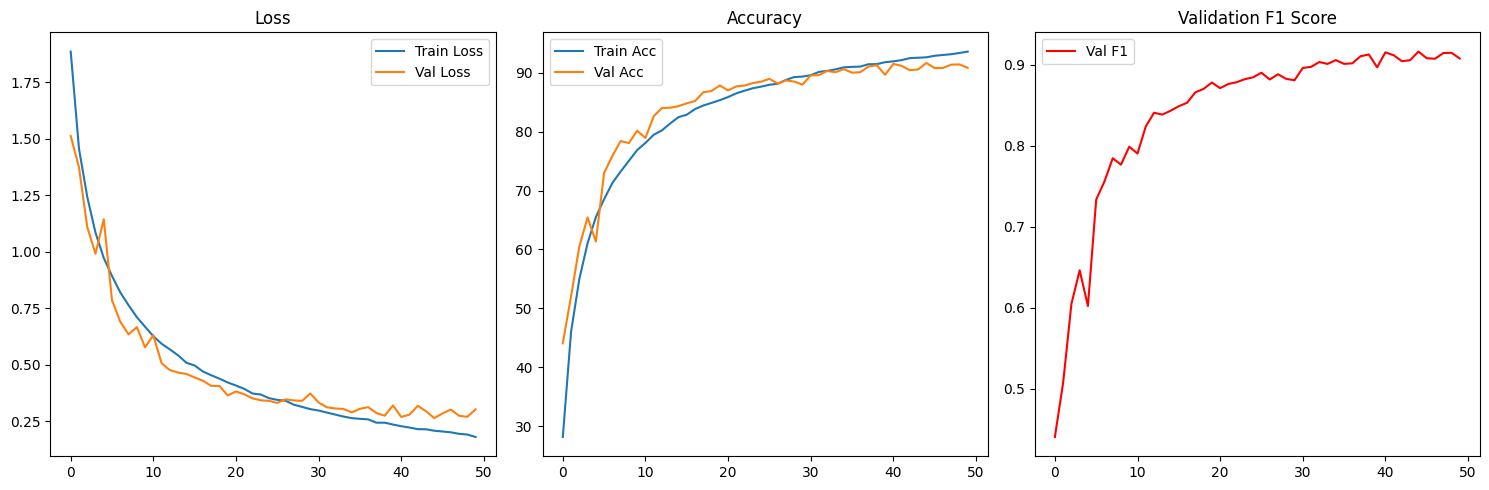

Training plots saved as 'model_results/best_model_training_plots.png'


In [14]:
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Create model directory if it doesn't exist
model_dir = "model_results"
os.makedirs(model_dir, exist_ok=True)
model_name = "best_model"

# Simple metrics tracking
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'val_precision': [], 'val_recall': [], 'val_f1': []
}

best_val_acc = 0
best_model_path = f"{model_dir}/{model_name}.pth"

class_names = ['airplane', 'auto', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for epoch in range(epochs):
    
    # ===== TRAINING =====
    net.train()
    train_loss, train_correct = 0, 0
    all_train_preds, all_train_labels = [], []
    
    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]'):
        images, labels = batch["img"].to(device), batch["label"].to(device)
        
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        preds = outputs.argmax(1)
        train_correct += (preds == labels).sum().item()
        
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())
    
    train_loss /= len(train_loader.dataset)
    train_acc = 100. * train_correct / len(train_loader.dataset)
    
    # ===== VALIDATION =====
    net.eval()
    val_loss, val_correct = 0, 0
    all_val_preds, all_val_labels, all_val_probs = [], [], []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]'):
            images, labels = batch["img"].to(device), batch["label"].to(device)
            
            outputs = net(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            
            probs = torch.softmax(outputs, dim=1)
            
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())
            all_val_probs.extend(probs.cpu().numpy())
    
    val_loss /= len(val_loader.dataset)
    val_acc = 100. * val_correct / len(val_loader.dataset)
    
    # ===== CONVERT TO NP ARRAYS & SAVE =====
    all_val_labels = np.array(all_val_labels)
    all_val_preds = np.array(all_val_preds)
    all_val_probs = np.array(all_val_probs)
    all_val_confidence = np.max(all_val_probs, axis=1)
    
    np.save(f'{model_dir}/{model_name}_val_probs.npy', all_val_probs)
    np.save(f'{model_dir}/{model_name}_val_preds.npy', all_val_preds)
    np.save(f'{model_dir}/{model_name}_val_labels.npy', all_val_labels)
    np.save(f'{model_dir}/{model_name}_val_confidence.npy', all_val_confidence)
    
    # ===== COMPUTE METRICS =====
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    val_precision = precision_score(all_val_labels, all_val_preds, average='macro', zero_division=0)
    val_recall = recall_score(all_val_labels, all_val_preds, average='macro', zero_division=0)
    val_f1 = f1_score(all_val_labels, all_val_preds, average='macro', zero_division=0)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)
    
    print(f"\nEpoch {epoch+1} Results:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"  Val Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f}")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # ===== SAVE BEST MODEL =====
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(net.state_dict(), best_model_path)
        print(f"NEW BEST MODEL! Val Acc: {val_acc:.2f}%")
        
        report = classification_report(all_val_labels, all_val_preds, target_names=class_names, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        report_df.to_csv(f'{model_dir}/{model_name}_classification_report.csv')
        
        cm = confusion_matrix(all_val_labels, all_val_preds)
        np.savetxt(f'{model_dir}/{model_name}_confusion_matrix.csv', cm, delimiter=',', fmt='%d')
    
    lr_scheduler.step(val_loss)

print(f"\nTraining Complete! Best Val Acc: {best_val_acc:.2f}%")

history_df = pd.DataFrame(history)
history_df.to_csv(f'{model_dir}/{model_name}_training_history.csv', index=False)
print(f"Training history saved to '{model_dir}/{model_name}_training_history.csv'")

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(history['val_f1'], label='Val F1', color='red')
plt.title('Validation F1 Score')
plt.legend()
plt.tight_layout()
plt.savefig(f'{model_dir}/{model_name}_training_plots.png', dpi=100, bbox_inches='tight')
plt.show()
print(f"Training plots saved as '{model_dir}/{model_name}_training_plots.png'")


In [20]:
print("Hello")

Hello


For ECE(Expected Calibration Error ) calculation we must first get the reuired things that is the confidence score , probabilities . predictions and Labels

In [21]:
base_path = "/kaggle/working/model_results/"
confidences = np.load(os.path.join(base_path, "best_model_val_confidence.npy"))  # (N,)
probs = np.load(os.path.join(base_path, "best_model_val_probs.npy"))             # (N, num_classes)
preds = np.load(os.path.join(base_path, "best_model_val_preds.npy"))             # (N,)
labels = np.load(os.path.join(base_path, "best_model_val_labels.npy")) if os.path.exists(os.path.join(base_path, "best_model_val_labels.npy")) else None

Expected Calibration Error (ECE) is a standard metric that measures how well a model’s predicted confidence aligns with its actual accuracy — in other words, how well the model “understands” its predictions and knows when it’s likely to be right or wrong.

In [22]:
def compute_ece(confidences, preds, labels, n_bins=15):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    bin_accs, bin_confs, bin_counts = [], [], []

    for i in range(n_bins):
        bin_lower, bin_upper = bins[i], bins[i + 1]
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            acc_in_bin = np.mean(preds[in_bin] == labels[in_bin])
            avg_conf_in_bin = np.mean(confidences[in_bin])
            ece += np.abs(acc_in_bin - avg_conf_in_bin) * prop_in_bin

            bin_accs.append(acc_in_bin)
            bin_confs.append(avg_conf_in_bin)
            bin_counts.append(np.sum(in_bin))
        else:
            bin_accs.append(0)
            bin_confs.append(0)
            bin_counts.append(0)
    return ece, bins, bin_accs, bin_confs, bin_counts

In [24]:
ece, bins, bin_accs, bin_confs, bin_counts = compute_ece(confidences, preds, labels)
print(f"Expected Calibration Error (ECE): {ece:.4f}")

Expected Calibration Error (ECE): 0.0350


**The model achieved an Expected Calibration Error (ECE) of 0.035, indicating that it is well-calibrated. In other words, the model’s predicted confidence closely matches its actual correctness**

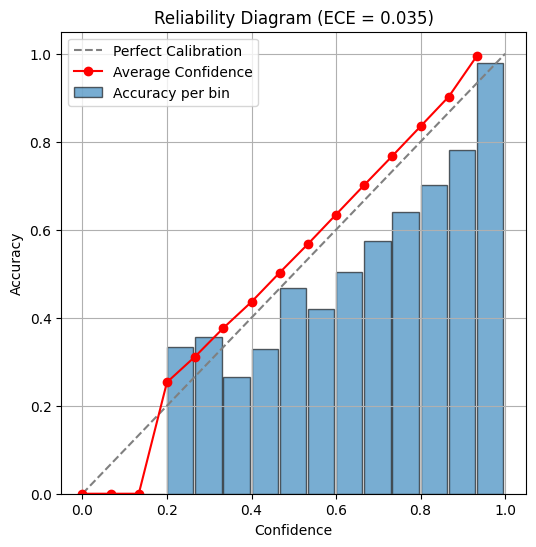

In [25]:
plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1],'--', color='gray', label='Perfect Calibration')
plt.bar(bins[:-1], bin_accs, width=1/len(bins), align='edge', edgecolor='black', alpha=0.6, label='Accuracy per bin')
plt.plot(bins[:-1], bin_confs, 'o-', color='red', label='Average Confidence')
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title(f'Reliability Diagram (ECE = {ece:.3f})')
plt.legend()
plt.grid(True)

In [26]:
plot_path = os.path.join(base_path, "reliability_diagram_val.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

with open(os.path.join(base_path, "ECE_val.txt"), "w") as f:
    f.write(f"Expected Calibration Error (ECE): {ece:.6f}\n")

print(f"Saved reliability diagram and ECE to: {base_path}")


<Figure size 640x480 with 0 Axes>

Saved reliability diagram and ECE to: /kaggle/working/model_results/
